In [41]:
import pandas as pd
import numpy as np
import matplotlib as plt
# import seaborn as sns

In [42]:
url1 = "https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/home_loan_train.csv"
# url2 = "https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/home_loan_test.csv"

In [43]:
df = pd.read_csv(url1)
# data2 = pd.read_csv(url2)

In [44]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [45]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [46]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [47]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [48]:
# dataset = pd.concat([data1, data2], axis=0, ignore_index=True)

# dataset.head()

In [49]:
# dataset.columns

In [50]:
# dataset.tail()

In [51]:
print(len(df))
# print(len(data2))
# print(len(dataset))



614


In [52]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [53]:
len(df)

614

In [54]:
df[df["Married"].isna()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [55]:
df.dropna(subset=["Married"], inplace=True)
df.dropna(subset=["Loan_Amount_Term"], inplace=True)
df.dropna(subset=["Gender"], inplace=True)
df.dropna(subset=["Dependents"], inplace=True)


In [56]:
df.isna().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        31
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term      0
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

In [57]:
df["LoanAmount"].fillna(df["LoanAmount"].mean(), inplace=True)

df["Self_Employed"].fillna(df["Self_Employed"].mode()[0], inplace=True)

df["Credit_History"].fillna(df["Credit_History"].median(), inplace=True)



C:\Users\oyeneye ayomide\AppData\Local\Temp\ipykernel_11140\1503891480.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["LoanAmount"].fillna(df["LoanAmount"].mean(), inplace=True)
C:\Users\oyeneye ayomide\AppData\Local\Temp\ipykernel_11140\1503891480.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [58]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [59]:
df.head(20)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.001808,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.000000,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.000000,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.000000,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,4006,1526.0,168.000000,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,12841,10968.0,349.000000,360.0,1.0,Semiurban,N


## Exploratory Data Analysis


In [60]:
df.shape

(573, 13)

In [61]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 573 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            573 non-null    object 
 1   Gender             573 non-null    object 
 2   Married            573 non-null    object 
 3   Dependents         573 non-null    object 
 4   Education          573 non-null    object 
 5   Self_Employed      573 non-null    object 
 6   ApplicantIncome    573 non-null    int64  
 7   CoapplicantIncome  573 non-null    float64
 8   LoanAmount         573 non-null    float64
 9   Loan_Amount_Term   573 non-null    float64
 10  Credit_History     573 non-null    float64
 11  Property_Area      573 non-null    object 
 12  Loan_Status        573 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.7+ KB


In [62]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,573.000000,573.000000,573.000000,573.000000,573.000000
mean,5328.514834,1641.359372,146.001808,341.675393,0.869110
std,5909.329219,3001.139055,82.569519,65.186012,0.337575
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2876.000000,0.000000,100.000000,360.000000,1.000000
50%,3812.000000,1210.000000,129.000000,360.000000,1.000000
75%,5815.000000,2302.000000,165.000000,360.000000,1.000000
max,81000.000000,41667.000000,650.000000,480.000000,1.000000


In [63]:
df.nunique()


Loan_ID              573
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      469
CoapplicantIncome    274
LoanAmount           200
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

### Univariate analysis

<Axes: xlabel='LoanAmount', ylabel='Count'>

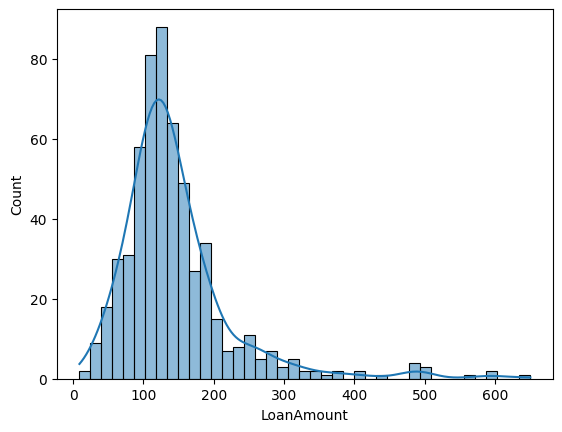

In [64]:
import seaborn as sns
sns.histplot(df["LoanAmount"], kde=True)

<Axes: xlabel='ApplicantIncome', ylabel='Count'>

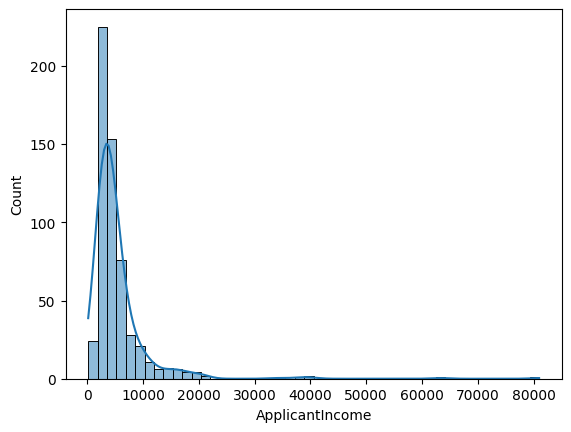

In [65]:
sns.histplot(df["ApplicantIncome"], kde=True)

<Axes: xlabel='LoanAmount'>

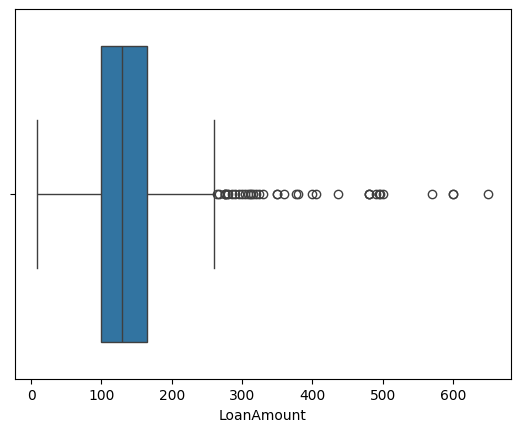

In [66]:
sns.boxplot(x=df["LoanAmount"])


<Axes: xlabel='Self_Employed', ylabel='count'>

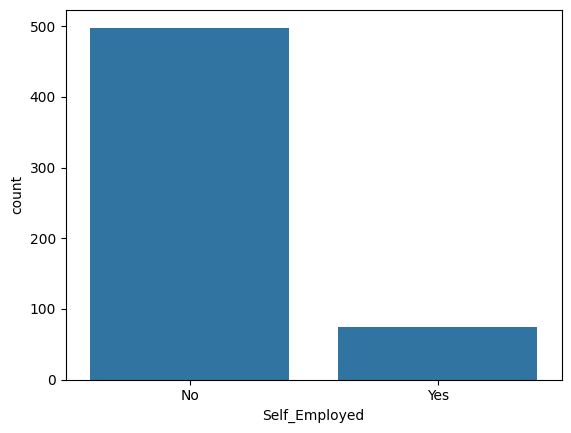

In [67]:
sns.countplot(x="Self_Employed", data=df)


<Axes: xlabel='Education', ylabel='count'>

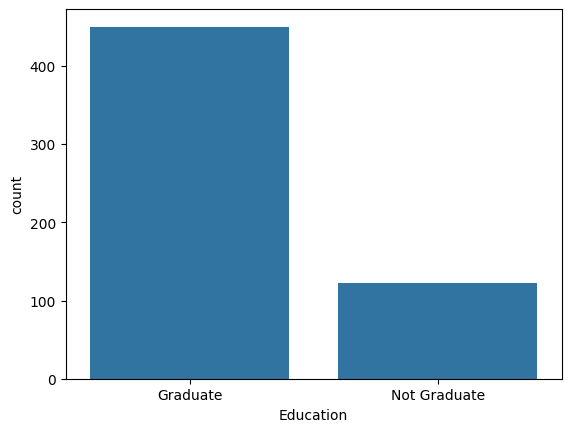

In [68]:
sns.countplot(x="Education", data=df)


### Bivariate Analysis

<Axes: xlabel='Education', ylabel='count'>

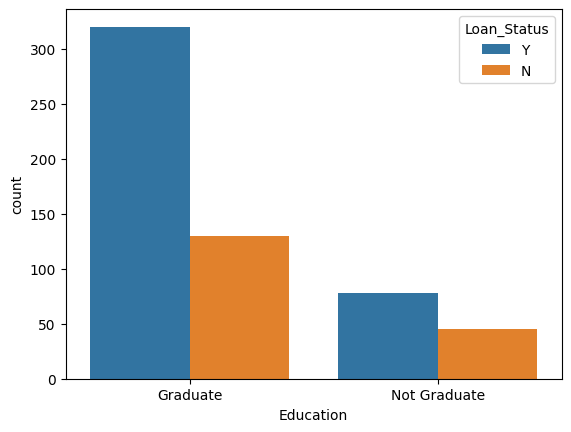

In [69]:
sns.countplot(x="Education", hue="Loan_Status", data=df)


<Axes: xlabel='Gender', ylabel='count'>

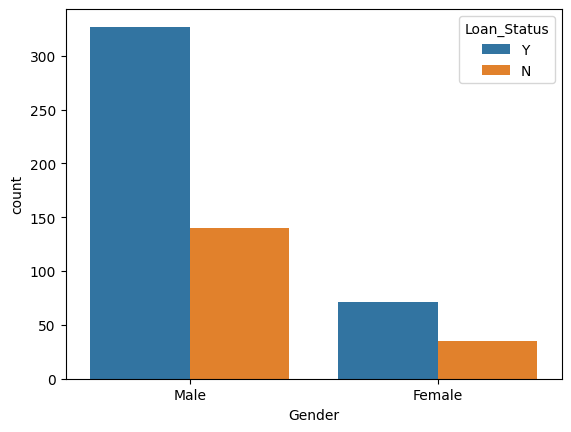

In [70]:
sns.countplot(x="Gender", hue="Loan_Status", data=df)


<Axes: xlabel='Married', ylabel='count'>

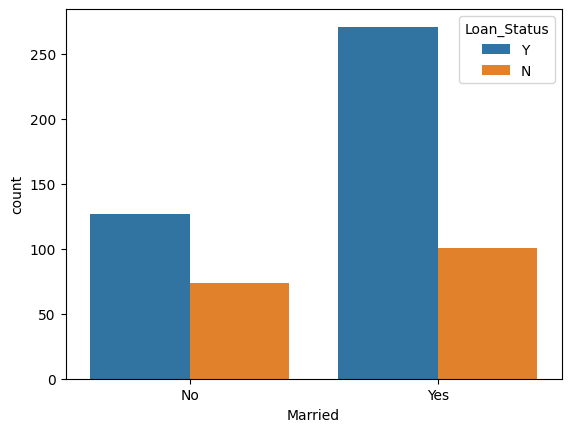

In [71]:
sns.countplot(x="Married", hue="Loan_Status", data=df)

In [72]:
average_income = df["ApplicantIncome"].mean()

high_income = df[df["ApplicantIncome"] > average_income]
lesser_income = df[df["ApplicantIncome"] < average_income]

In [73]:
def get_income_rating():
    for _, item in df.iterrows():
        if item["ApplicantIncome"] > average_income:
            return ("High")
        else:
            return ("Low")


In [74]:
df["income_rating"] = get_income_rating()

In [75]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,income_rating
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.001808,360.0,1.0,Urban,Y,High
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N,High
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y,High
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y,High
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y,High


<Axes: xlabel='income_rating', ylabel='count'>

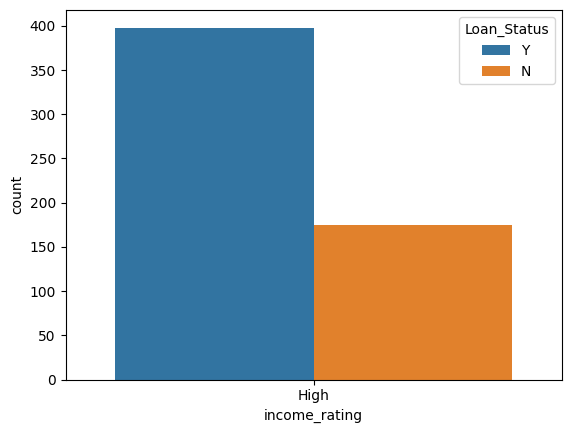

In [76]:
sns.countplot(x="income_rating", hue="Loan_Status", data=df)
